## Calculating Dynamic topography

Set `ekey` below to plot different experiments.

In [1]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import xarray as xr
import scipy as sp
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client, progress

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/dynamic_topo"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
cnes_clim_tstart = pd.to_datetime('1993', format='%Y')
cnes_clim_tend = cnes_clim_tstart + pd.DateOffset(years=20)

In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.6.43.39:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.6.43.39:8786 --local-directory /local/g40/aek156`
* Then, make sure the following cell matches the scheduler address.

In [4]:
client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.1.23:8786' processes=1 threads=48, memory=188.56 GiB>

In [6]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_level')
darray = var_search.to_dask()
darray = darray['sea_level']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(cnes_clim_tstart,cnes_clim_tend)).mean('time') #, skipna=True)
mdt_1deg = sea_level.load() + 0.5  #NOTE: minor correction to MSL

CPU times: user 968 ms, sys: 302 ms, total: 1.27 s
Wall time: 21.6 s


In [7]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_level')
darray = var_search.to_dask()
darray = darray['sea_level']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(cnes_clim_tstart,cnes_clim_tend)).mean('time')
mdt_025deg = sea_level.load() + 0.5  #NOTE: minor correction to MSL

CPU times: user 622 ms, sys: 50.1 ms, total: 672 ms
Wall time: 1min 17s


In [11]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

cat_subset = catalog[expt]
var_search = cat_subset.search(frequency='1 daily', variable='eta_t')
darray = var_search.to_dask()
darray = darray['eta_t']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(cnes_clim_tstart,cnes_clim_tend)).mean('time')
mdt_01deg = sea_level.load() + 0.5 #NOTE: minor correction to MSL

CPU times: user 19.8 s, sys: 883 ms, total: 20.7 s
Wall time: 1h 21min 49s


In [12]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/mdt_cnes_cls2013_global.nc'
MDT = xr.open_dataset(aviso_file).mdt.mean('time')

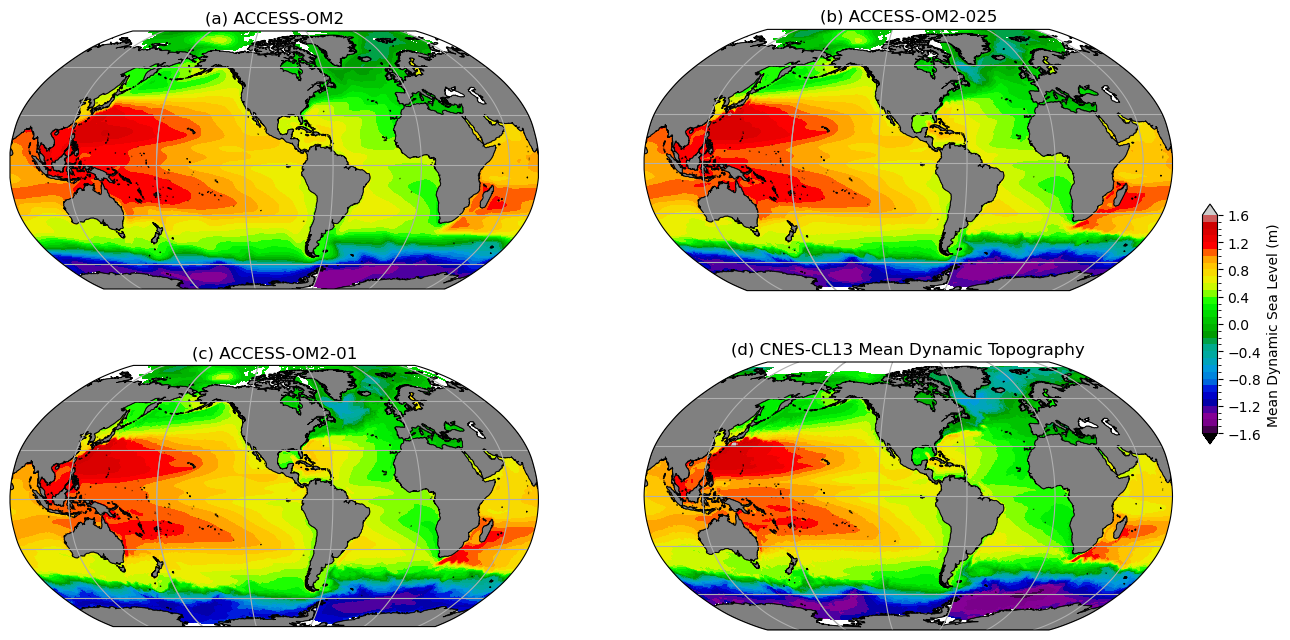

In [13]:
plt.figure(figsize=(15,8))
clev = np.arange(-1.6,1.601,0.1)
# cmp = cm.cm.balance
cmp = plt.get_cmap('nipy_spectral')


land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
    
ax = plt.subplot(2,2,1,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = mdt_1deg.plot.contourf(cmap=cmp,levels=clev,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())
p1.cmap.set_under(color=cmp(0), alpha=None)
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.title('(a) ACCESS-OM2')

ax = plt.subplot(2,2,2,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = mdt_025deg.plot.contourf(cmap=cmp,levels=clev,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())
p1.cmap.set_under(color=cmp(0), alpha=None)
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.title('(b) ACCESS-OM2-025')

ax = plt.subplot(2,2,3,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = mdt_01deg.plot.contourf(cmap=cmp,levels=clev,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())
p1.cmap.set_under(color=cmp(0), alpha=None)
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.title('(c) ACCESS-OM2-01')

ax = plt.subplot(2,2,4,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = MDT.plot(cmap=cmp,levels=clev,add_colorbar=False,
                        extend='both',transform=ccrs.PlateCarree())
p1.cmap.set_under(color=cmp(0), alpha=None)
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.title('(d) CNES-CL13 Mean Dynamic Topography')

ax3 = plt.axes([0.92,0.35,0.01,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Mean Dynamic Sea Level (m)')
savefigure('mean_dynamic_topography')


## TODO
work out why there are white patches in polar regions

- it's not over-saturation of the colour scale

- `mean('time', skipna=True)` doesn't fix it